These are the variables being used:
- 'label': 0 or 1 (integer; which is SITB_ABSENT or SITB_PRESENT)
- 'reputation' (float between 0 and 1)
- 'contact_size' (float between 0 and 1)

- 'type': categorical, either: 0 (comment), 0.5 (question) or 1 (StatusUpdate)
- 'tag': list of strings, e.g., ['health', 'veterans', 'affairs', 'benefits' , 'military', 'family' , 'veterans', 'health', 'administration']

In [56]:
os

<module 'os' from '/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/os.py'>

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scattertext import SampleCorpora, PhraseMachinePhrases, dense_rank, RankDifference, AssociationCompactor, produce_scattertext_explorer
from scattertext.CorpusFromPandas import CorpusFromPandas
import scattertext as st

on_google_drive = False

if on_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    input_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/input/'
    output_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/output/'
else:
    input_dir = './data/input/final_datasets/'
    output_dir = './data/output/semantic_analysis/'
    

/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv(input_dir + 'train.csv')

In [3]:
train_metadata = train[['label', 'reputation', 'contact_size', 'type', 'tags']]
train_metadata

,label,reputation,contact_size,type,tags
0,0.0,0.000047,0.000344,0.0,"[""donald trump""]"
1,0.0,0.167313,0.081946,0.0,"[""ptsd"",""substance use"",""victory for veterans""]"
2,1.0,0.000000,0.000000,0.0,NaN
3,0.0,0.000450,0.001375,0.0,"[""marriage"",""children"",""ptsd"",""service""]"
4,0.0,0.024174,0.014190,0.0,"[""command post"",""jumpmaster instructor"",""82nd ..."
...,...,...,...,...,...
6473,0.0,0.021059,0.046939,0.0,"[""world history"",""american history"",""food chow..."
6474,0.0,0.000000,0.000000,0.0,NaN
6475,0.0,0.000041,0.000638,0.0,"[""realtor"",""real estate"",""transition""]"
6476,0.0,0.042655,0.005450,0.0,"[""humor""]"


In [4]:
train['type'].unique()

array([0. , 1. , 0.5])

In [50]:
type_map = {0: 'comment',
            0.5: 'question', 
            1: 'status update'}

label_map = {0: 'Nonsuicidal',
            1: 'Suicidal'}

train_metadata['type'] = train['type'].map(type_map)
train_metadata['label'] = train['label'].map(label_map)

type_stats = train_metadata.groupby('label')['type'].value_counts(normalize=True)
display((type_stats*100).round(1))
# display(train_metadata.groupby('label')['type'].value_counts(normalize=True))


/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_61845/3405652691.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metadata['type'] = train['type'].map(type_map)
/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_61845/3405652691.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metadata['label'] = train['label'].map(label_map)


label        type         
Nonsuicidal  comment          85.9
             status update     9.3
             question          4.8
Suicidal     comment          91.4
             question          4.6
             status update     4.1
Name: proportion, dtype: float64

# Tags

In [25]:
train_stb_tags.sum()

counts    1216
dtype: int64

In [69]:
from collections import Counter
train_stb = train_metadata[train_metadata['label']=='Nonsuicidal']
train_nonstb = train_metadata[train_metadata['label']=='Suicidal']

def return_most_freq_tags(train_stb, n =10):
    
    train_stb_tags = [eval(str(n)) for n in train_stb['tags'].values if str(n)!= 'nan']
    train_stb_tags = [n for i in train_stb_tags for n in i]
    
    train_stb_tags = pd.DataFrame(Counter(train_stb_tags), index = ['Counts']).T
    train_stb_tags['Counts (%)'] = ((train_stb_tags/train_stb_tags.sum())*100).round(1)
    train_stb_tags['Counts % (N)'] = train_stb_tags['Counts (%)'].astype(str)+' ('+train_stb_tags['Counts'].astype(str)+')'
    train_stb_tags = train_stb_tags.sort_values('Counts')[::-1]
    
    top_n = (train_stb_tags.index +' '+ train_stb_tags['Counts (%)'].astype(str)).values[:n]
    for i in top_n:
        print(i)
    return train_stb_tags

train_stb_tags = return_most_freq_tags(train_stb, n =10)
display(train_stb_tags)
# train_nonstb_tags = [eval(n) for n in train_nonstb['tags'].values]




ptsd 3.6
humor 2.5
suicide 2.2
veterans affairs 1.8
victory for veterans 1.5
health 1.4
mental health 1.1
motivation 1.0
inspiration 1.0
transition 1.0


,Counts,Counts (%),Counts % (N)
ptsd,547,3.6,3.6 (547)
humor,383,2.5,2.5 (383)
suicide,335,2.2,2.2 (335)
veterans affairs,267,1.8,1.8 (267)
victory for veterans,222,1.5,1.5 (222)
...,...,...,...
car audio,1,0.0,0.0 (1)
military sticker,1,0.0,0.0 (1)
rudy giuliani,1,0.0,0.0 (1)
paralyzed veterans of america,1,0.0,0.0 (1)


In [49]:


train_nonstb_tags = return_most_freq_tags(train_nonstb, n =10)
display(train_nonstb_tags)





ptsd 3.6
humor 2.5
suicide 2.2
veterans affairs 1.8
victory for veterans 1.5
health 1.4
mental health 1.1
motivation 1.0
inspiration 1.0
transition 1.0


,Counts,Counts (%),Counts % (N)
ptsd,547,3.6,3.6 (547)
humor,383,2.5,2.5 (383)
suicide,335,2.2,2.2 (335)
veterans affairs,267,1.8,1.8 (267)
victory for veterans,222,1.5,1.5 (222)
...,...,...,...
car audio,1,0.0,0.0 (1)
military sticker,1,0.0,0.0 (1)
rudy giuliani,1,0.0,0.0 (1)
paralyzed veterans of america,1,0.0,0.0 (1)


# Contact size

In [59]:
import seaborn as sns
sns.__version__

'0.12.2'

In [67]:
train_stb

,label,reputation,contact_size,type,tags


In [76]:
output_dir

'./data/output/semantic_analysis/'

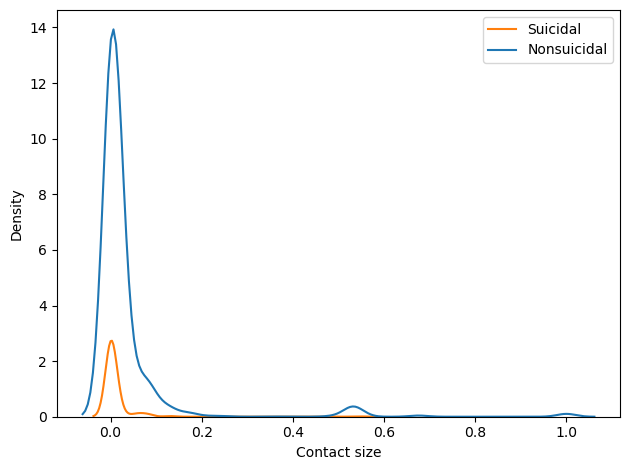

In [83]:
type_map = {0: 'comment',
            0.5: 'question', 
            1: 'status update'}



sns.kdeplot(data=train_metadata, hue='label', x='contact_size')

plt.legend(title=None, labels = ['Suicidal', 'Nonsuicidal'])
plt.xlabel('Contact size')
plt.tight_layout()

plt.savefig('./data/output/density_contact_size.png', dpi=150)

plt.show()
# type_stats = train_metadata.groupby('label')['type'].value_counts(normalize=True)
# type_stats
# display(train_metadata.groupby('label')['type'].value_counts(normalize=True))


In [80]:
train_metadata

,label,reputation,contact_size,type,tags
0,Nonsuicidal,0.000047,0.000344,comment,"[""donald trump""]"
1,Nonsuicidal,0.167313,0.081946,comment,"[""ptsd"",""substance use"",""victory for veterans""]"
2,Suicidal,0.000000,0.000000,comment,NaN
3,Nonsuicidal,0.000450,0.001375,comment,"[""marriage"",""children"",""ptsd"",""service""]"
4,Nonsuicidal,0.024174,0.014190,comment,"[""command post"",""jumpmaster instructor"",""82nd ..."
...,...,...,...,...,...
6473,Nonsuicidal,0.021059,0.046939,comment,"[""world history"",""american history"",""food chow..."
6474,Nonsuicidal,0.000000,0.000000,comment,NaN
6475,Nonsuicidal,0.000041,0.000638,comment,"[""realtor"",""real estate"",""transition""]"
6476,Nonsuicidal,0.042655,0.005450,comment,"[""humor""]"


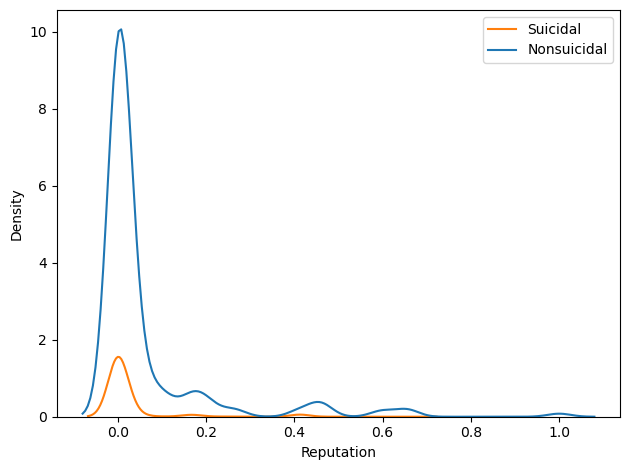

In [82]:


sns.kdeplot(data=train_metadata, hue='label', x='reputation')

plt.legend(title=None, labels = ['Suicidal', 'Nonsuicidal'])
plt.xlabel('Reputation')
plt.tight_layout()

plt.savefig('./data/output/density_reputation_size.png', dpi=150)

plt.show()
# type_stats = train_metadata.groupby('label')['type'].value_counts(normalize=True)
# type_stats
# display(train_metadata.groupby('label')['type'].value_counts(normalize=True))


# OTHER

In [8]:
train_metadata.groupby('label')['tags']

<AxesSubplot: xlabel='label,tags'>

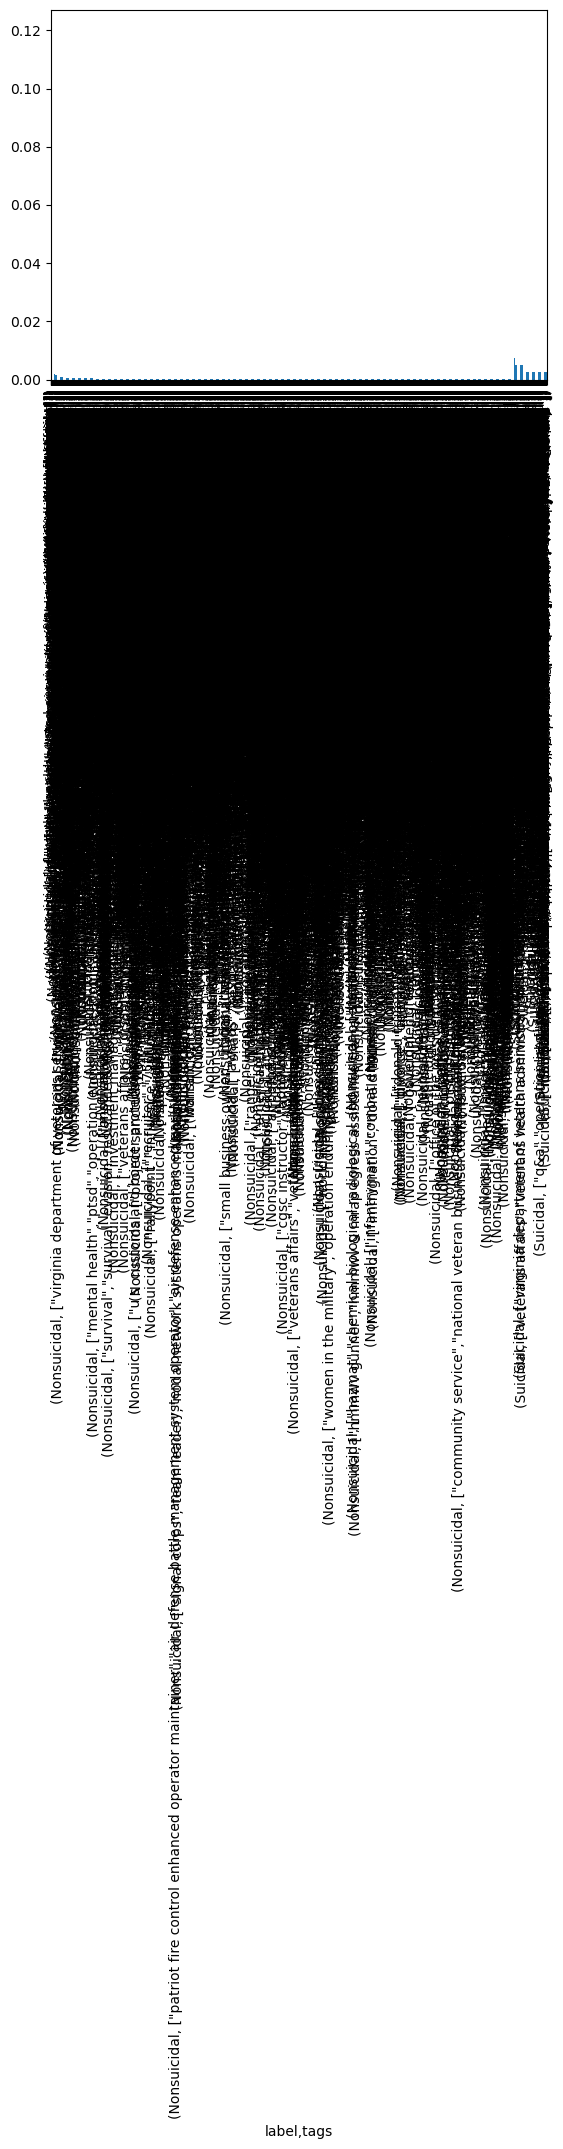

In [7]:
type_stats = train_metadata.groupby('label')['tags'].value_counts(normalize=True)
type_stats.plot(kind='bar')